<a href="https://colab.research.google.com/github/Jsshang/DataProcessingForLab/blob/main/Trials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from typing import *
import os

In [3]:
folder = 'drive/MyDrive/toshare'

In [5]:
def getPeakInfos(filePath: str, peak_index_offset: int = 13500, min_freq_diff: int = None) -> Tuple[float, float, float, float, float]:
  """
    Get the location and the power of the left peak and the right peak.
  
    Parameters:
    filePath (str): the input csv file with two columns, the first column represent frequency, the second column represent power.
    peak_index_offset (int): the index offset when we find left peak and right peak
    min_freq_diff (int)
  
    Returns:
    Tuple[float, float, float, float, float]: left peak frequency, left peak power, right peak frequency, right peak power, max peak frequency
  """
  df = pd.read_csv(filePath)
  df.columns = ["frequency", "power"]

  frequencies = df["frequency"].values
  powers = df["power"].values

  maxPowerIdx = np.argmax(powers)
  maxPeakFreq = frequencies[maxPowerIdx]

  powerPeaksIndices, _ = find_peaks(powers, prominence=5)  # BEST!

  rightPeakIdx = powerPeaksIndices[-1]
  for rightPeakIdx in powerPeaksIndices[::-1]:
    if rightPeakIdx < maxPowerIdx + peak_index_offset:
      break

  rightPeakFreq = frequencies[rightPeakIdx]
  rightPeakPower = powers[rightPeakIdx]
  if min_freq_diff and rightPeakFreq - maxPeakFreq < min_freq_diff:
    rightPeakFreq = maxPeakFreq + 1000
    rightPeakPower = 0

  leftPeakIdx = powerPeaksIndices[0]
  for leftPeakIdx in powerPeaksIndices:
    if leftPeakIdx > maxPowerIdx - peak_index_offset:
      break
  
  leftPeakFreq = frequencies[leftPeakIdx]
  leftPeakPower = powers[leftPeakIdx]
  if min_freq_diff and maxPeakFreq - leftPeakFreq < min_freq_diff:
    leftPeakFreq = maxPeakFreq - 1000
    leftPeakPower = 0

  return (leftPeakFreq, leftPeakPower, rightPeakFreq, rightPeakPower, maxPeakFreq)


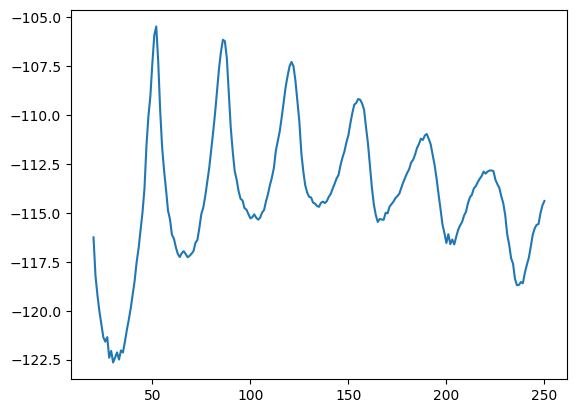

In [ ]:
# Trail 1
x_axis = [i for i in range(20, 251)]
left_f, left_peak, right_f, right_peak = [], [], [], []

diff = []

for i in range(20, 251):

    csv_name = f"{folder}/Trial1/{i}.0MHz.csv"

    leftF, leftP, rightF, rightP, maxF = getPeakInfos(csv_name)
    right_f.append(rightF)
    diff.append(rightF - maxF)
    right_peak.append(rightP)

df1 = pd.DataFrame()
df1['Freq[MHz]'] = x_axis
df1['right_frequency'] = right_f
df1['right_peak'] = right_peak

import statistics
std_dev = statistics.stdev(diff)
# print(std_dev)

# plt.plot(x_axis, right_peak)
plt.plot(x_axis, right_peak)
plt.show()

In [ ]:
# Trail 2
df2_left = pd.DataFrame()
df2_right = pd.DataFrame()
df2_left['Freq[MHz]'] = [i for i in range(20, 251, 5)]
df2_right['Freq[MHz]'] = [i for i in range(20, 251, 5)]

for ph in range(4, 10):
  leftPeaks = []
  rightPeaks = []  
  leftFreqsDiff = []
  rightFreqsDiff = []
  for freq in range(20, 251, 5):
    fileName = f"{folder}/Trial2/PH{ph}/{freq}.0MHz.csv"
    leftF, leftP, rightF, rightP, maxF = getPeakInfos(fileName, peak_index_offset = 8500)
    leftFreqsDiff.append(maxF - leftF)
    leftPeaks.append(leftP)
    rightFreqsDiff.append(rightF - maxF)
    rightPeaks.append(rightP)
  
  df2_left[f'PH{ph}'] = leftPeaks
  df2_right[f'PH{ph}'] = rightPeaks
  df2_left[f'PH{ph}_pk_freq_diff'] = leftFreqsDiff
  df2_right[f'PH{ph}_pk_freq_diff'] = rightFreqsDiff


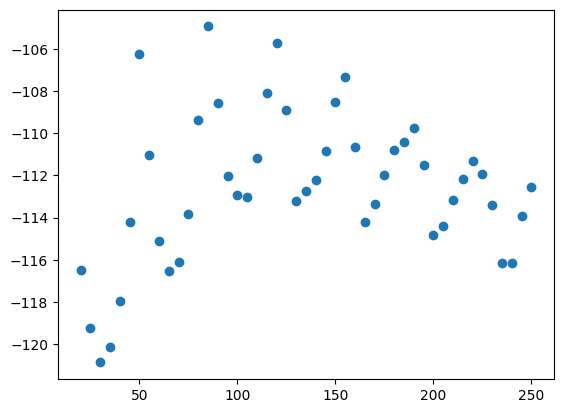

In [ ]:
df2_right.head()
# for ph in range(4, 10):
#   print(df2_left[f'PH{ph}_pk_freq_diff'].std())
# example

# print(df2_right['PH4'])
x_axis = [i for i in range(20, 251, 5)]
plt.scatter(x_axis, df2_right['PH5'])
plt.show()

In [ ]:
df2_left.round(2).to_csv(f"{folder}/df2_left.csv", index=False)
df2_right.round(2).to_csv(f"{folder}/df2_right.csv", index=False)

In [ ]:
# Trial 3
trial3Folder = f"{folder}/Trial3"

# df = pd.DataFrame(columns=['PH', 'BgAc', 'BgDc', 'DS', 'LeftPower', 'RightPower', 'LeftFreqDiff', 'RightFreqDiff'])
m = {
    'PH': [], 
    'BgAc': [],
    'BgDc': [], 
    'DS': [], 
    'LeftPower': [], 
    'RightPower': [], 
    'LeftFreqDiff': [], 
    'RightFreqDiff': []
}

for ph in (0, 4, 7, 9):
  phDir = f"PH{ph}"
  for bgAc in (10, 20, 30):
    for bgDc in range(-2, 3):
      bgDir = f"B-{bgAc}-{abs(bgDc)}"
      if bgDc > 0:
        bgDir = f"B-{bgAc}+{bgDc}"
      for ds in range(-40, 11, 10):
        fileName = f"{ds}dBm_-30_0offset.csv"
        filePath = f"{trial3Folder}/{phDir}/{bgDir}/{fileName}"
        leftF, leftP, rightF, rightP, maxF = getPeakInfos(filePath, peak_index_offset = 8500, min_freq_diff = 950)
        leftFreqDiff = maxF - leftF
        rightFreqDiff = rightF - maxF
        m['PH'].append(ph) 
        m['BgAc'].append(bgAc)
        m['BgDc'].append(bgDc) 
        m['DS'].append(ds) 
        m['LeftPower'].append(leftP) 
        m['RightPower'].append(rightP) 
        m['LeftFreqDiff'].append(leftFreqDiff) 
        m['RightFreqDiff'].append(rightFreqDiff)

df3 = pd.DataFrame(m)


In [ ]:
df3.head()
df3['RightFreqDiff'].std()

0.5693839444992121

In [ ]:
df3.tail(5)

,PH,BgAc,BgDc,DS,LeftPower,RightPower,LeftFreqDiff,RightFreqDiff
355,9,30,2,-30,0.0,0.0,1000.0,1000.0
356,9,30,2,-20,0.0,0.0,1000.0,1000.0
357,9,30,2,-10,0.0,0.0,1000.0,1000.0
358,9,30,2,0,0.0,0.0,1000.0,1000.0
359,9,30,2,10,0.0,0.0,1000.0,1000.0


In [ ]:
df3.round(2).to_csv(f"{folder}/df3.csv")

In [ ]:
filter_df = df3[(df3['LeftFreqDiff'] > 800) & (df3['LeftFreqDiff'] < 950)]
filter_df = df3[(df3['RightFreqDiff'] > 800) & (df3['RightFreqDiff'] < 950)]
filter_df

,PH,BgAc,BgDc,DS,LeftPower,RightPower,LeftFreqDiff,RightFreqDiff


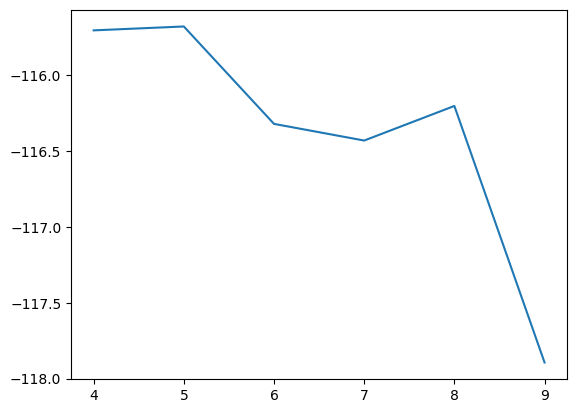

In [8]:
# Trail5

x_axis = [i for i in range(4, 10)]
left_f, left_peak, right_f, right_peak = [], [], [], []
error, diff = [], []

for i in range(4, 10):

  right_peak_stat = []
  right_peak_loc_stat = []
  diff_temp = []

  for j in range(10):

    csv_name = f"{folder}/Trial5/PH{i}/{j}.csv"

    leftF, leftP, rightF, rightP, maxF = getPeakInfos(csv_name)
    right_peak_loc_stat.append(rightF)
    right_peak_stat.append(rightP)
    # right_f.append(rightF)
    # diff.append(rightF - maxF)
    # right_peak.append(rightP)

  right_f.append(np.average(right_peak_loc_stat))
  right_peak.append(np.average(right_peak_stat))

df5 = pd.DataFrame()
df5['Freq[MHz]'] = x_axis
df5['right_frequency'] = right_f
df5['right_peak'] = right_peak

# import statistics
# std_dev = statistics.stdev(diff)
# print(std_dev)

# plt.plot(x_axis, right_peak)
plt.plot(x_axis, right_peak)
plt.show()

